# DataJoint Elements Tutorial: Miniscope

Welcome to the tutorial for DataJoint's open-source data pipeline for miniature
fluorescent microscope imaging (miniscope). This tutorial aims to provide a comprehensive understanding of the
open-source data pipeline created using `element-miniscope` for processing
and analyzing neuronal calcium dynamics acquired with the UCLA Miniscope and Miniscope DAQ. 

**In this tutorial, we will cover:**
- The basics:
  - Differentiating between an Element, module, schema, table, and pipeline.
  - How to plot an overview of the pipeline with `dj.Diagram`.
- Hands-on interactions with the pipeline:
  - Inserting real data into tables.
  - Querying table contents.
  - Fetching table contents.
- A walk-through:
  - Processing miniscope imaging data acquired with UCLA miniscope and Miniscope DAQ V4.

**Additional Resources:**
- [Interactive Tutorials](https://github.com/datajoint/datajoint-tutorials) on `datajoint-python`: Dive deep into DataJoint's fundamentals.
- [*`datajoint-python`* Documentation](https://datajoint.com/docs/core/datajoint-python/): Comprehensive documentation on DataJoint for Python.
- [Element Miniscope
  Documentation](https://datajoint.com/docs/elements/element-miniscope/): Detailed guide
  on the DataJoint Element for Miniscope Imaging.

Before we jump into the core concepts, let's ensure we have all the necessary packages imported.

In [1]:
import datajoint as dj
import datetime
import matplotlib.pyplot as plt
import numpy as np

## Combine multiple Elements into a pipeline

Each DataJoint Element is a modular set of tables that can be combined into a complete
pipeline. Here are the definitions for clarity:

+ **Module**: In Python, a module is a file containing definitions and statements. In the context of DataJoint, modules often define and structure related database tables.
+ **Table**: A structured set of data held within the database. It consists of rows and
  columns, much like an Excel spreadsheet.
+ **Schema**: Think of a schema as a container or namespace within the database where related tables are grouped together. It helps organize and manage the database structure.
+ **Element**: A modular set of related tables. 

---

Each Element contains 1 or more modules, and each module declares its own schema in the database.

This tutorial pipeline is assembled from four DataJoint Elements.

| Element | Source Code | Documentation | Description |
| -- | -- | -- | -- |
| Element Lab | [Link](https://github.com/datajoint/element-lab) | [Link](https://datajoint.com/docs/elements/element-lab) | Lab management related information, such as Lab, User, Project, Protocol, Source. |
| Element Animal | [Link](https://github.com/datajoint/element-animal) | [Link](https://datajoint.com/docs/elements/element-animal) | General animal metadata and surgery information. |
| Element Session | [Link](https://github.com/datajoint/element-session) | [Link](https://datajoint.com/docs/elements/element-session) | General information of experimental sessions. |
| Element Miniscope | [Link](https://github.com/datajoint/element-miniscope) | [Link](https://datajoint.com/docs/elements/element-miniscope) |  Miniscope Imaging analysis with CaImAn. |

By importing the modules for the first time, the schemas and tables will be created in
the database.  Once created, importing modules will not create schemas and tables
again, but will allow access to existing schemas/tables.

The Elements are imported and activated within the `tutorial_pipeline` script.

In [2]:
from tutorial_pipeline import (
    lab,
    subject,
    session,
    miniscope,
)

[2023-11-08 21:19:10,053][WARNING]: lab.Project and related tables will be removed in a future version of Element Lab. Please use the project schema.
[2023-11-08 21:19:10,055][INFO]: Connecting root@fakeservices.datajoint.io:3306
[2023-11-08 21:19:10,063][INFO]: Connected root@fakeservices.datajoint.io:3306


Each Python module (e.g. `subject`) contains a schema object that enables interaction with the schema in the database.

In [3]:
subject.schema

Schema `neuro_subject`

The Python classes in the module correspond to a table in the database server.

In [4]:
subject.Subject()

subject,subject_nickname,sex,subject_birth_date,subject_description


## Diagram

Let's plot the diagram of tables within multiple schemas and their dependencies using `dj.Diagram()`.

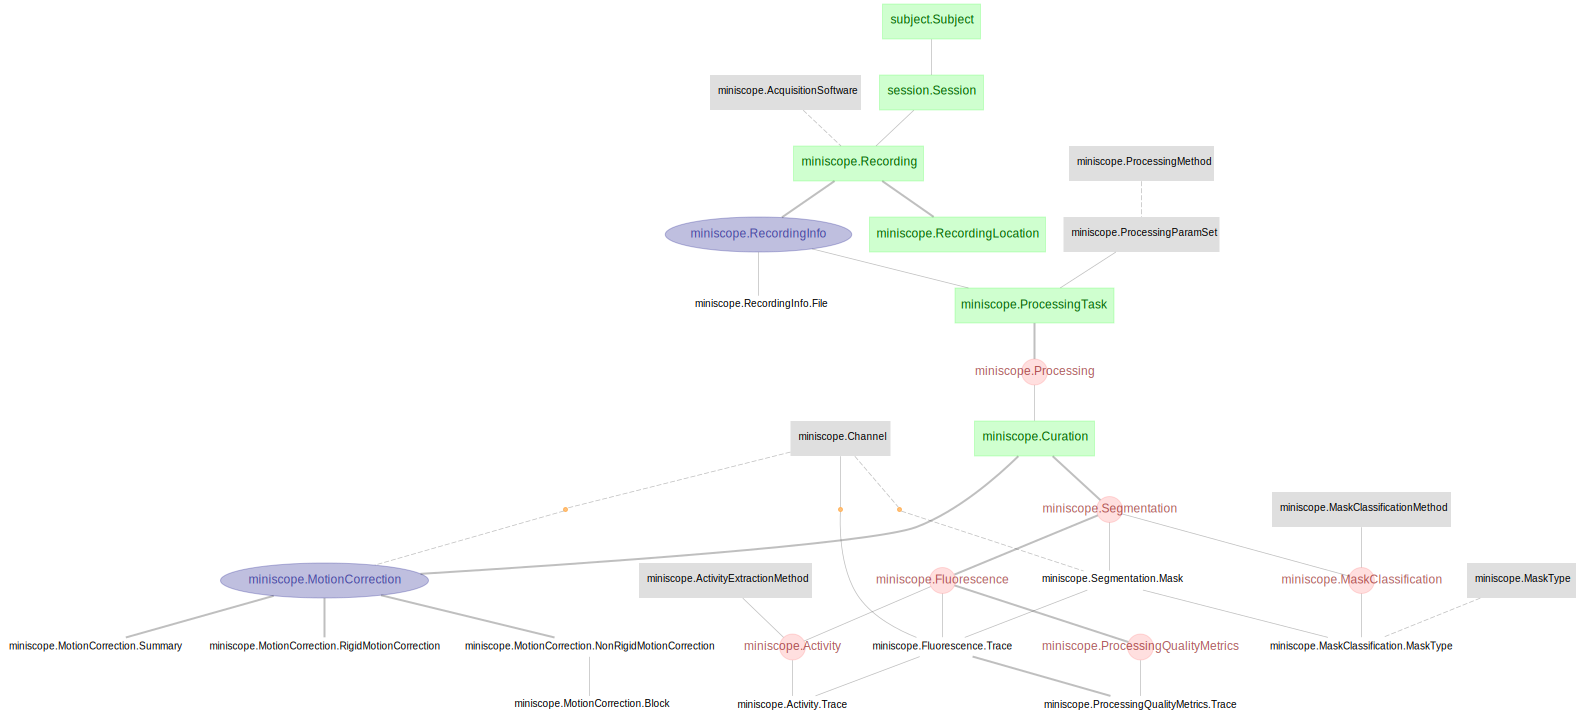

In [5]:
(dj.Diagram(subject.Subject) + dj.Diagram(session.Session) + dj.Diagram(miniscope))

## Understanding Table Types in DataJoint

In the previous cell, we visualized the relationships between various tables in our pipeline using `dj.Diagram`. As you might have noticed, tables have different colors and shapes. This is because, in DataJoint, tables can be of different types, each serving a unique purpose.

| Table tier | Color and shape | Description | Practical Example |
| -- | -- | -- | -- |
| **Manual table** | Green box | Data entered manually, either by hand or with external helper scripts. | A table containing data about individual subjects, like their birth date or sex. |
| **Lookup table** | Gray box | Small tables containing general, non-changing information or settings. | A table containing available experimental protocols or animal species. |
| **Imported table** | Blue oval | Data automatically ingested but requiring external data. | A table that pulls data from an external file or dataset. |
| **Computed table** | Red circle | Data computed entirely within the pipeline. | A table calculating metrics or statistics from previously stored data. |
| **Part table** | Plain text | Tables associated with a master table, sharing its tier. | A subtable containing specific measurements for each subject in a master subject table. |

### Order matters!

The arrangement of tables in the `dj.Diagram` is not arbitrary. It represents the flow of data and dependencies:

- **Higher-up Tables**: These are typically your starting point. For instance, before you can insert data about an experimental session, you need to have data about the subject of that session.
- **Dependencies**: Tables connected by a line have dependencies. For example, before
  you can populate data about an experiment's results, you need to insert data about the
  experiment setup.

**Quick Check**: Based on the diagram, which tables do you think we would insert data into first?

---

## Interacting with DataJoint Pipelines

DataJoint offers a powerful set of commands that allow us to interact with the pipeline:

- **Insert**: Manually add data to a table.
- **Populate**: Automatically compute and insert data.
- **Query**: Search and filter data.
- **Fetch**: Retrieve data for further analysis or visualization.

In the upcoming sections, we'll get hands-on with these commands. Let's start by
understanding how to manually insert data into our pipeline!

---

### Insert entries into manual tables

Manual tables serve as the foundation upon which our pipeline builds. By entering data
here, we lay the groundwork for subsequent automated analyses.

Let's start with the first table in the schema diagram (i.e. `subject.Subject` table).

To know what data to insert into the table, we can view its dependencies and attributes using the `.describe()` and `.heading` functions.

In [6]:
print(subject.Subject.describe())

subject              : varchar(8)                   
---
subject_nickname=""  : varchar(64)                  
sex                  : enum('M','F','U')            
subject_birth_date   : date                         
subject_description="" : varchar(1024)                



In [7]:
subject.Subject.heading

# 
subject              : varchar(8)                   # 
---
subject_nickname=""  : varchar(64)                  # 
sex                  : enum('M','F','U')            # 
subject_birth_date   : date                         # 
subject_description="" : varchar(1024)                # 

The cells above show all attributes of the subject table.
We will insert data into the
`subject.Subject` table. 

In [8]:
subject.Subject.insert1(
    dict(subject="subject1", subject_birth_date="2023-01-01", sex="U")
)
subject.Subject()

subject,subject_nickname,sex,subject_birth_date,subject_description
subject1,,U,2023-01-01,


Let's repeat the steps above for the `Session` table and see how the output varies between
`.describe` and `.heading`.

In [9]:
print(session.Session.describe())

-> subject.Subject
session_datetime     : datetime                     



In [10]:
session.Session.heading

# 
subject              : varchar(8)                   # 
session_datetime     : datetime                     # 

Notice that `describe`, displays the table's structure and highlights its dependencies, such as its reliance on the `Subject` table. These dependencies represent foreign key references, linking data across tables.

On the other hand, `heading` provides an exhaustive list of the table's attributes. This
list includes both the attributes declared in this table and any inherited from upstream
tables.

With this understanding, let's move on to insert a session associated with our subject.

We will insert into the `session.Session` table by passing a dictionary to the `insert1` method.

In [11]:
session_key = dict(subject="subject1", session_datetime="2023-01-01 00:00:00")

In [12]:
session.Session.insert1(session_key)
session.Session()

subject,session_datetime
subject1,2023-01-01 00:00:00


#### Introducing the `SessionDirectory` Table

Every experimental session produces a set of data files. The `SessionDirectory` table's
purpose is to locate these files. It references a directory path relative to a root
directory, defined in `dj.config["custom"]`. More
information about `dj.config` is provided in the [User
Guide](https://datajoint.com/docs/elements/user-guide/).

In [13]:
session.SessionDirectory.insert1(dict(**session_key, session_dir="session1"))
session.SessionDirectory()

subject,session_datetime,session_dir Path to the data directory for a session
subject1,2023-01-01 00:00:00,session1


As the workflow diagram indicates, the first table in the `miniscope` schema is the `miniscope.Recording` table.

In [16]:
print(miniscope.Recording.describe())

-> session.Session
recording_id         : int                          
---
-> lab.Device
-> miniscope.AcquisitionSoftware
recording_notes=""   : varchar(4095)                # free-notes



In [15]:
miniscope.Recording.heading

# 
subject              : varchar(8)                   # 
session_datetime     : datetime                     # 
recording_id         : int                          # 
---
device               : varchar(32)                  # 
acq_software         : varchar(24)                  # 
recording_notes=""   : varchar(4095)                # free-notes

As you can see from the `describe()` method, this lab contains a dependency on the `Device` table within the `lab` schema. Let's quickly insert a miniscope device before inserting into `miniscope.Recording`. 

In [17]:
lab.Device.heading

# 
device               : varchar(32)                  # 
---
modality             : varchar(64)                  # 
description=""       : varchar(256)                 # 

In [18]:
lab.Device.insert1(dict(device="miniscope A", modality="miniscope"))

In [19]:
miniscope.Recording.insert1(
    dict(
        **session_key,
        recording_id=1,
        device="miniscope A",
        acq_software="Miniscope-DAQ-V4",
    )
)

## Populate

### Automatically populate tables

`miniscope.RecordingInfo` is the first table in this pipeline that can be
automatically populated using using the `populate()` method.

In DataJoint, the `populate()` method is a powerful feature designed to fill tables based on the logic defined in the table's `make` method. Here's a breakdown of its functionality:

- **Automation**: Instead of manually inserting data into each table, which can be error-prone and time-consuming, `populate()` automates the insertion based on the dependencies and relationships already established in the schema.

- **Dependency Resolution**: Before populating a table, `populate()` ensures all its dependencies are populated. This maintains the integrity and consistency of the data.

- **Part Tables**: If a table has part tables associated with it, calling `populate()` on the main table will also populate its part tables. This is especially useful in cases like `miniscope.RecordingInfo` and its part table `miniscope.RecordingInfo.File`, as they are closely linked in terms of data lineage.

- **Restriction**: The `populate()` method can be restricted to specific entries. For instance, by providing a `session_key`, we're ensuring the method only operates on the data relevant to that particular session. This is both efficient and avoids unnecessary operations.

In the upcoming cells, we'll make use of the `populate()` method to fill the `miniscope.RecordingInfo` table and its part table. Remember, while this operation is automated, it's essential to understand the underlying logic to ensure accurate and consistent data entry.


In [20]:
miniscope.RecordingInfo()

subject,session_datetime,recording_id,nchannels number of channels,nframes number of recorded frames,px_height height in pixels,px_width width in pixels,um_height height in microns,um_width width in microns,fps (Hz) frames per second,gain recording gain,"spatial_downsample e.g. 1, 2, 4, 8. 1 for no downsampling",led_power LED power used in the given recording,time_stamps time stamps of each frame,recording_datetime datetime of the recording,recording_duration (seconds) duration of the recording


In [21]:
miniscope.RecordingInfo.File()

subject,session_datetime,recording_id,file_id,file_path relative to root data directory


In [22]:
miniscope.RecordingInfo.populate(session_key, display_progress=True)

RecordingInfo: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


Let's view the information was entered into each of these tables:

In [24]:
miniscope.RecordingInfo()

subject,session_datetime,recording_id,nchannels number of channels,nframes number of recorded frames,px_height height in pixels,px_width width in pixels,um_height height in microns,um_width width in microns,fps (Hz) frames per second,gain recording gain,"spatial_downsample e.g. 1, 2, 4, 8. 1 for no downsampling",led_power LED power used in the given recording,time_stamps time stamps of each frame,recording_datetime datetime of the recording,recording_duration (seconds) duration of the recording
subject1,2023-01-01 00:00:00,1,1,111770,600,600,nan,nan,20.0,2.0,1,5.0,=BLOB=,None,5588.5


In [25]:
miniscope.RecordingInfo.File()

subject,session_datetime,recording_id,file_id,file_path relative to root data directory
subject1,2023-01-01 00:00:00,1,0,session1/0.avi


We're almost ready to perform image processing with `CaImAn`. An important step before
processing is managing the parameters which will be used in that step. To do so, we will
define the `CaImAn` parameters in a dictionary and insert them into a DataJoint table
`ProcessingParamSet`. This table keeps track of all combinations of your image
processing parameters. You can choose which parameters are used during processing in a
later step.

Let's view the attributes and insert data into `miniscope.ProcessingParamSet`.

In [26]:
miniscope.ProcessingParamSet.heading

# Parameter set used for processing of miniscope data
paramset_idx         : smallint                     # 
---
processing_method    : varchar(16)                  # 
paramset_desc        : varchar(128)                 # 
param_set_hash       : uuid                         # 
params               : longblob                     # dictionary of all applicable parameters

In [27]:
params = dict(
    decay_time=0.4,
    pw_rigid=False,
    max_shifts=(5, 5),
    gSig_filt=(3, 3),
    strides=(48, 48),
    overlaps=(24, 24),
    max_deviation_rigid=3,
    border_nan="copy",
    method_init="corr_pnr",
    K=None,
    gSig=(3, 3),
    gSiz=(13, 13),
    merge_thr=0.7,
    p=1,
    tsub=2,
    ssub=1,
    rf=40,
    stride=20,
    only_init=True,
    nb=0,
    nb_patch=0,
    method_deconvolution="oasis",
    low_rank_background=None,
    update_background_components=True,
    min_corr=0.8,
    min_pnr=10,
    normalize_init=False,
    center_psf=True,
    ssub_B=2,
    ring_size_factor=1.4,
    del_duplicates=True,
    border_pix=0,
    min_SNR=3,
    rval_thr=0.85,
    use_cnn=False,
)


miniscope.ProcessingParamSet.insert_new_params(
    processing_method="caiman",
    paramset_id=0,
    paramset_desc="Miniscope analysis with CaImAn using default parameters",
    params=params,
)

NameError: name 'ephys' is not defined

Now that we've inserted kilosort parameters into the `ProcessingParamSet` table,
we're almost ready to run image processing. DataJoint uses a `ProcessingTask` table to
manage which `Recording` and `ProcessingParamSet` should be used during processing. 

This table is important for defining several important aspects of
downstream processing. Let's view the attributes to get a better understanding. 

In [28]:
miniscope.ProcessingTask.heading

# Manual table marking a processing task to be triggered or manually processed
subject              : varchar(8)                   # 
session_datetime     : datetime                     # 
recording_id         : int                          # 
paramset_idx         : smallint                     # 
---
processing_output_dir : varchar(255)                 # relative to the root data directory
task_mode="load"     : enum('load','trigger')       # 'load': load existing results

The `ProcessingTask` table contains two important attributes: 
+ `paramset_id` 
+ `task_mode` 

The `paramset_id` attribute tracks
your kilosort parameter sets. You can choose the parameter set using which 
you want spike sort ephys data. For example, `paramset_id=0` may contain
default parameters for kilosort processing whereas `paramset_id=1` contains your custom parameters for sorting. This
attribute tells the `Processing` table which set of parameters you are processing in a given `populate()`.

The `task_mode` attribute can be set to either `load` or `trigger`. When set to `load`,
running the processing step initiates a search for exisiting kilosort output files. When set to `trigger`, the
processing step will run kilosort on the raw data. 

In [ ]:
miniscope.ProcessingTask.insert1(
    dict(
        **session_key,
        recording_id=1,
        paramset_id=0,
        task_mode="load",  # load or trigger
        processing_output_dir="session1",
    )
)

In [ ]:
miniscope.Processing.populate(session_key, display_progress=True)

While spike sorting is completed in the above step, you can optionally curate
the output of image processing using the `Curation` table. For this demo, we
will simply use the results of the spike sorting output from the `Clustering` task.

In [ ]:
miniscope.Curation.heading

In [ ]:
clustering_key = (miniscope.ProcessingTask & session_key).fetch1("KEY")
miniscope.Curation().create1_from_clustering_task(clustering_key)

Once the `Curation` table receives an entry, we can populate the remaining
tables in the workflow including `CuratedClustering`, `WaveformSet`, and `LFP`. 

In [ ]:
miniscope.CuratedClustering.populate(session_key, display_progress=True)
miniscope.MotionCorrection.populate(session_key, display_progress=True)
miniscope.Segmentation.populate(session_key, display_progress=True)
miniscope.Fluorescence.populate(session_key, display_progress=True)
miniscope.Activity.populate(session_key, display_progress=True)

Now that we've populated the tables in this workflow, there are one of
several next steps. If you have an existing workflow for
aligning waveforms to behavior data or other stimuli, you can easily
invoke `element-event` or define your custom DataJoint tables to extend the
pipeline.

In this tutorial, we will do some exploratory analysis by fetching the data from the database and creating a few plots.

## Querying Data

DataJoint provides a powerful querying system, allowing you to retrieve and work with data stored in your database seamlessly. In this section, we'll explore the fundamental querying concepts.

#### What is a Query?

- A query is essentially a request for data. With DataJoint, you can craft specific queries to fetch data that meets your criteria from the database.

#### The `fetch()` Method

- The primary method for retrieving data from a DataJoint table is `fetch()`.
- **Default Behavior**: Without any arguments, `fetch()` returns a list of dictionaries. Each dictionary corresponds to an entry in the table.
  
#### The `fetch1()` Method

- For tables with a single entry or when you're only interested in the first entry, use `fetch1()`.
- **Default Behavior**: It returns a dictionary of attributes for that one entry.

#### Specific Attributes

- Both `fetch()` and `fetch1()` can be made more specific by providing attributes.
- Example: `fetch1('fps')` will retrieve only the `fps` attribute from the first entry.

#### Restricting Queries

- Often, you don't want to fetch everything. Instead, you might want data related to a specific subject or session.
- DataJoint uses the `&` operator to restrict queries.
- Example: To get all session times for `subject5`, you might use:
  ```python
  subject1_times = (session.Session & "subject = 'subject1'").fetch("session_datetime")
  ```

#### Fetching Primary Keys

- Sometimes, you just need the primary keys of entries.
- Use the `fetch("KEY")` syntax for this. For instance, `(session.Session).fetch("KEY")`.

#### Let's Dive In!

Now that we've established the basics, let's delve deeper into querying with some practical examples.

In [ ]:
lfp_average = (ephys.LFP & "insertion_number = '1'").fetch1("lfp_mean")

In the query above, we fetch a single `lfp_mean` attribute from the `LFP` table.
We also restrict the query to insertion number 1.

Let's go ahead and plot the LFP mean.

In [ ]:
plt.plot(lfp_average)
plt.title("Average LFP Waveform for Insertion 1")
plt.xlabel("Samples")
plt.ylabel("microvolts (uV)")

DataJoint queries are a highly flexible tool to manipulate and visualize your data.
After all, visualizing traces or generating rasters is likely just the start of
your analysis workflow. This can also make the queries seem more complex at
first. However, we'll walk through them slowly to simplify their content in this notebook. 

The examples below perform several operations using DataJoint queries:
- Fetch the primary key attributes of all units that are in `insertion_number=1`.
- Use **multiple restrictions** to fetch timestamps and create a raster plot.
- Use a **join** operation and **multiple restrictions** to fetch a waveform
  trace, along with unit data to create a single waveform plot

In [ ]:
insert_key = (ephys.ProbeInsertion & "insertion_number = '1'").fetch1("KEY")
units, unit_spiketimes = (
    ephys.CuratedClustering.Unit
    & insert_key
    & 'unit IN ("6","7","9","14","15","17","19")'
).fetch("unit", "spike_times")

In [ ]:
x = np.hstack(unit_spiketimes)
y = np.hstack([np.full_like(s, u) for u, s in zip(units, unit_spiketimes)])
plt.plot(x, y, "|")
plt.xlabel("Time (s)")
plt.ylabel("Unit")

In [ ]:
unit_key = (ephys.CuratedClustering.Unit & insert_key & "unit = '15'").fetch1("KEY")
unit_data = (
    ephys.CuratedClustering.Unit * ephys.WaveformSet.PeakWaveform & unit_key
).fetch1()

In [ ]:
unit_data

In [ ]:
sampling_rate = (ephys.EphysRecording & insert_key).fetch1(
    "sampling_rate"
) / 1000  # in kHz
plt.plot(
    np.r_[: unit_data["peak_electrode_waveform"].size] * 1 / sampling_rate,
    unit_data["peak_electrode_waveform"],
)
plt.xlabel("Time (ms)")
plt.ylabel(r"Voltage ($\mu$V)")

## Conclusion

Throughout this notebook, we've used DataJoint to work with database tables and keep
data organized and automate analyses to increase efficiency of data processing. We've
inserted data into tables, used queries to retrieve, manipulate, and visualize ephys data.

Remember, this is just the beginning. As you grow familiar with DataJoint, you'll
uncover even more ways to harness its capabilities for your specific research needs. 

---

To run this tutorial notebook on your own data, please use the following steps:
- Download the mysql-docker image for DataJoint and run the container according to the
  instructions provide in the repository.
- Create a fork of this repository to your GitHub account.
- Clone the repository and open the files using your IDE.
- Add a code cell immediately after the first code cell in the notebook - we will setup
  the local connection using this cell. In this cell, type in the following code. 

```python
import datajoint as dj
dj.config["database.host"] = "localhost"
dj.config["database.user"] = "<your-username>"
dj.config["database.password"] = "<your-password>"
dj.config["custom"] = {"imaging_root_data_dir": "path/to/your/data/dir",
"database_prefix": "<your-username_>"}
dj.config.save_local()
dj.conn()
```

- Run this code block above and proceed with the rest of the notebook.